By default tensors and model parameters in PyTorch are stored in 32-bit floating point precision. Training neural networks using 32-bit floats is usually stable and doesn't cause major numerical issues, however neural networks have been shown to perform quite well in 16-bit and even lower precisions. Computation in lower precisions can be significantly faster on modern GPUs. It also has the extra benefit of using less memory enabling training larger models and/or with larger batch sizes which can boost the performance further. The problem though is that training in 16 bits often becomes very unstable because the precision is usually not enough to perform some operations like accumulations.

To help with this problem PyTorch supports training in mixed precision. In a nutshell mixed-precision training is done by performing some expensive operations (like convolutions and matrix multplications) in 16-bit by casting down the inputs while performing other numerically sensitive operations like accumulations in 32-bit. This way we get all the benefits of 16-bit computation without its drawbacks. Next we talk about using Autocast and GradScaler to do automatic mixed-precision training.

#### Autocast

`autocast` helps improve runtime performance by automatically casting down data to 16-bit for some computations. To understand how it works let's look at an example:

In [1]:
import torch

x = torch.rand([32, 32]).cuda()
y = torch.rand([32, 32]).cuda()

with torch.cuda.amp.autocast():
  a = x + y
  b = x @ y
print(a.dtype)  # prints torch.float32
print(b.dtype)  # prints torch.float16

torch.float32
torch.float16


Note both x and y are 32-bit tensors, but autocast performs matrix multiplication in 16-bit while keeping addition operation in 32-bit. What if one of the operands is in 16-bit?

In [2]:
import torch

x = torch.rand([32, 32]).cuda()
y = torch.rand([32, 32]).cuda().half()

with torch.cuda.amp.autocast():
  a = x + y
  b = x @ y
print(a.dtype)  # prints torch.float32
print(b.dtype)  # prints torch.float16

torch.float32
torch.float16


Again autocast and casts down the 32-bit operand to 16-bit to perform matrix multiplication, but it doesn't change the addition operation. By default, addition of two tensors in PyTorch results in a cast to higher precision.

In practice, you can trust autocast to do the right casting to improve runtime efficiency. The important thing is to keep all your forward pass computations under autocast context:

In [3]:
# model = ...
# loss_fn = ...

# with torch.cuda.amp.autocast():
#   outputs = model(inputs)
#   loss = loss_fn(outputs, targets)

This maybe all you need if you have a relatively stable optimization problem and if you use a relatively low learning rate. Adding this one line of extra code can reduce your training up to half on modern hardware.

#### Gradscaler
As we mentioned in the beginning of this section, 16-bit precision may not always be enough for some computations. One particular case of interest is representing gradient values, a great portion of which are usually small values. Representing them with 16-bit floats often leads to buffer underflows (i.e. they'd be represented as zeros). This makes training neural networks very unstable. `GradScalar` is designed to resolve this issue. It takes as input your loss value and multiplies it by a large scalar, inflating gradient values, and therefore making them represnetable in 16-bit precision. It then scales them down during gradient update to ensure parameters are updated correctly. This is generally what `GradScalar` does. But under the hood `GradScalar` is a bit smarter than that. Inflating the gradients may actually result in overflows which is equally bad. So `GradScalar` actually monitors the gradient values and if it detects overflows it skips updates, scaling down the scalar factor according to a configurable schedule. (The default schedule usually works but you may need to adjust that for your use case.)

Using `GradScalar` is very easy in practice:

In [4]:
# scaler = torch.cuda.amp.GradScaler()

# loss = ...
# optimizer = ...  # an instance torch.optim.Optimizer

# scaler.scale(loss).backward()
# scaler.step(optimizer)
# scaler.update()

Note that we first create an instance of GradScalar. In training loop we call GradScalar.scale to scale the loss before calling backward to produce inflated gradients, we then use GradScalar.step which (may) update the model parameters. We then call GradScalar.update which performs the scalar update if needed. That's all!

##### Generating a Checkerboard


In [5]:
import torch
import matplotlib.pyplot as plt

def grid(width, height):
    hrange = torch.arange(width).unsqueeze(0).repeat([height, 1]).div(width)
    vrange = torch.arange(height).unsqueeze(1).repeat([1, width]).div(height)
    output = torch.stack([hrange, vrange], 0)
    return output

def checker(width, height, freq):
    hrange = torch.arange(width).reshape([1, width]).mul(freq / width / 2.0).fmod(1.0).gt(0.5)
    vrange = torch.arange(height).reshape([height, 1]).mul(freq / height / 2.0).fmod(1.0).gt(0.5)
    output = hrange.logical_xor(vrange).float()
    return output

inputs = grid(512, 512).unsqueeze(0).cuda()
targets = checker(512, 512, 8).unsqueeze(0).unsqueeze(1).cuda()


**Explanation**:

`grid()` function generates a grid of coordinates normalized between 0 and 1.   

`checker()` function generates a checkerboard pattern based on the grid coordinates.   

`inputs` represent the grid coordinates, and targets represent the corresponding checkerboard pattern.   

##### Defining a Convolutional Neural Network


In [6]:
class Net(torch.jit.ScriptModule):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(2, 256, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 1, 1)
        )

    @torch.jit.script_method
    def forward(self, x):
        return self.net(x)

**Explanation**:

`Net` class defines a convolutional neural network architecture using `torch.nn.Sequential`.

The network consists of several convolutional layers with batch normalization and ReLU activation.

The `forward` method defines the forward pass of the network.

##### Single Precision Training

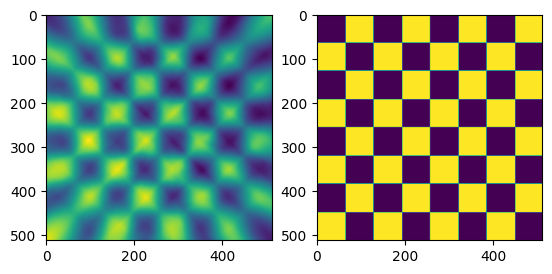

In [7]:
net = Net().cuda()
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), 0.001)

for i in range(500):
    opt.zero_grad()
    outputs = net(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    opt.step()

plt.subplot(1,2,1); plt.imshow(outputs.squeeze().detach().cpu());
plt.subplot(1,2,2); plt.imshow(targets.squeeze().cpu()); plt.show()


**Explanation**:

`net` is initialized and moved to the GPU.

Single precision training loop runs for `500` iterations.

Loss is computed using `Mean Squared Error (MSE)` between outputs and targets.

Backpropagation is performed and optimizer updates the parameters.

Final outputs and targets are visualized using matplotlib.

##### Mixed Precision Training

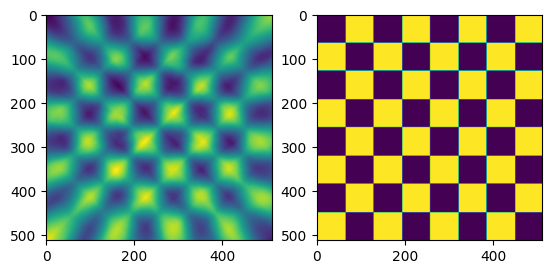

In [8]:
net = Net().cuda()
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), 0.001)

scaler = torch.cuda.amp.GradScaler()

for i in range(500):
    opt.zero_grad()
    with torch.cuda.amp.autocast():
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()

plt.subplot(1,2,1); plt.imshow(outputs.squeeze().detach().cpu().float());
plt.subplot(1,2,2); plt.imshow(targets.squeeze().cpu().float()); plt.show()

**Explanation**:

Similar to single precision training, but with additional scaler object for mixed precision.

`torch.cuda.amp.autocast()` context is used to automatically cast certain operations to 16-bit precision.

Loss is scaled using `scaler.scale(loss)` before backward pass.

Optimizer step is taken using `scaler.step(opt)` to update the model parameters.

`scaler.update()` is called to update the scaler state.